### Mount drive
*It would be better to save unziped images to Google Drive because unzip takes much time  
*NO! It takes more time to load images from the drive than to unzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DR mini dataset: 888 (DR:237, NORMAL:651)  
DR mini dataset ver.2: 9998 (DR:2629, NORMAL:7369)  
DR mini dataset ver.3: 5118 (DR:2629, NORMAL:2489)  
DR dataset: 17845 (DR:8974, NORMAL:8871):

In [ ]:
!unzip '/content/drive/MyDrive/deep learning/DiabeticRetinopathy/DR_mini_dataset.zip'

In [ ]:
!unzip '/content/drive/MyDrive/deep learning/DiabeticRetinopathy/DR_mini_dataset2.zip'

In [ ]:
!unzip '/content/drive/MyDrive/deep learning/DiabeticRetinopathy/DR_mini_dataset3.zip'

In [ ]:
!unzip '/content/drive/MyDrive/deep learning/DiabeticRetinopathy/DR_dataset.zip'

## Transfer Learning (starts from here)
  
This site explains about fine-tuning transfer learning.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.resnet50 import ResNet50

In [ ]:
DATA_DIR = "/content/DR_mini_dataset2/train" # When unzip works properly
# DATA_DIR = "/content/drive/MyDrive/Dataset/DiabeticRetinopathy/DR_dataset" # When load not-zip images from Google Drive because unzip donsnt work properly now...
MODEL_DIR = "/content/drive/MyDrive/Global_PGM/3 KMUTT Lectures/CognitiveComputing/classProject/model"

PRETRAINED_MODEL = 'vgg16'
# PRETRAINED_MODEL = 'resnet'
# PRETRAINED_MODEL = 'efficientnet'

MODEL_NAME = 'DRDetection_TL_'+PRETRAINED_MODEL

IMG_WIDTH, IMG_HEIGHT = 224, 224 # 224x224 is Default input size for VGG16

TEST_RATIO = 0.2
VALIDATION_RATIO = 0.2

EPOCHS = 500
BATCH_SIZE = 64
SAVE_MODEL_PER_EPOCH = 25

In [ ]:
import os
no_of_class = len(os.listdir(DATA_DIR))

### Extract features through pretrained model
Get feature output from pretrained model

In [ ]:
# Instantiate convolutional base
if PRETRAINED_MODEL == 'vgg16':
    # # Similarly, it might be better to app GlobalAveragePooling layere to base model like resnet
    # conv_base = VGG16(include_top=False, weights='imagenet', Input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    vgg16 = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
    top = vgg16.output
    top = GlobalAveragePooling2D()(top)
    conv_base = Model(inputs=vgg16.input, outputs=top)
    del vgg16, top

elif PRETRAINED_MODEL == 'resnet':
    # # I could not run simple fine tuning due to RAM depletion
    # conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    # # Instead, add GlobalAveragePooling2D layer to conv_base
    resnet = ResNet50(include_top=False,
                       weights='imagenet',
                       input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    top = resnet.output
    top = GlobalAveragePooling2D()(top)
    conv_base = Model(inputs=resnet.input, outputs=top)
    del resnet, top

elif PRETRAINED_MODEL == 'efficientnet':
    conv_base = EfficientNetB0(include_top=False,
                               weights='imagenet',
                               input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                               pooling='max')

# Show architecture
conv_base.summary()
conv_base_output_shape = conv_base.output_shape

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
# Extract features through pretrained model
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def extract_features(model, directory, sample_count, batch_size):
    input_shape = np.array(model.output_shape)
    input_shape[0] = sample_count

    features = np.zeros(shape=input_shape)  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,no_of_class))

    # Preprocess data
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(directory,
                                            target_size=(model.input_shape[1],model.input_shape[2]),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        print("\r[{cr}%] ({cr_no}/{whole_no})".format(cr=100*batch_size*i//sample_count,
                                                      cr_no=batch_size*i,
                                                      whole_no=sample_count
                                                      ), end='')
        features_batch = model.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    print("\r[100%] ({cr_no}/{whole_no})".format(cr_no=sample_count,whole_no=sample_count), end='')

    return features, labels

def count_data(directory):
    class_list = os.listdir(directory)
    data_num = 0
    for c in class_list:
        data_num += len(os.listdir(directory+'/'+c))
    return data_num


data_features, data_labels = extract_features(model=conv_base,
                                              directory=DATA_DIR,
                                              sample_count=count_data(DATA_DIR),
                                              batch_size=4)
del conv_base

Found 17845 images belonging to 2 classes.
[100%] (17845/17845)

In [ ]:
# Split test data   # In the Sequential.fit(), the rest data is splited into train and validation data
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(data_features, data_labels, test_size=TEST_RATIO)

print("Train:", train_features.shape)
print("Test :", test_features.shape)
del data_features
del data_labels

Train: (14276, 512)
Test : (3569, 512)


### Train Top-output model

In [ ]:
from keras.optimizers import Adam

# Create model
model = Sequential()

if PRETRAINED_MODEL == 'vgg16':
    # model.add(GlobalAveragePooling2D(input_shape=conv_base_output_shape[1:])) # This layer is added to base model
    model.add(Dense(512, activation='relu', input_shape=[conv_base_output_shape[1]]))
    model.add(Dropout(rate=0.2))
    model.add(Dense(no_of_class, activation='softmax'))

elif PRETRAINED_MODEL == 'resnet':
    # model.add(GlobalAveragePooling2D(input_shape=conv_base_output_shape[1:])) # This layer is added to base model
    model.add(Dense(512, activation='relu', input_shape=[conv_base_output_shape[1]]))
    model.add(Dropout(rate=0.2))
    model.add(Dense(no_of_class, activation='softmax'))

elif PRETRAINED_MODEL == 'efficientnet':
    model.add(Dense(512, activation='relu', input_shape=[conv_base_output_shape[1]]))
    model.add(Dropout(rate=0.2))
    model.add(Dense(no_of_class, activation='softmax'))

model.summary()

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 263,682
Trainable params: 263,682
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# F1 score (ref:https://qiita.com/koshian2/items/81abfc0a75ea99f726b9)
from sklearn.metrics import f1_score
from keras.callbacks import Callback

class F1Callback(Callback):
    def __init__(self, model, X_val, y_val):
        self.model = model
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs):
        pred = self.model.predict(self.X_val)
        f1_val = f1_score(self.y_val, np.round(pred), average='micro')
        print("f1_val =", f1_val)
        # Add checkpoint or others if need

# Check point
from keras.callbacks import ModelCheckpoint
save_per_epoch = SAVE_MODEL_PER_EPOCH
model_name = MODEL_NAME+'_{w:04d}x{h:04d}-{batch:04d}'.format(w=IMG_WIDTH, h=IMG_HEIGHT, batch=BATCH_SIZE)
checkpoint = ModelCheckpoint(filepath=MODEL_DIR+'/'+model_name+'-{epoch:03d}.h5',
                             verbose=1,
                             monitor='val_loss',
                             save_best_only=False,
                             save_freq=save_per_epoch * len(train_features) // BATCH_SIZE,
                             mode='auto')

In [ ]:
# Train model
history = model.fit(x=train_features,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, F1Callback(model, test_features, test_labels)],
                    validation_split=VALIDATION_RATIO,
                    shuffle=1,
                    steps_per_epoch=(len(train_features)*VALIDATION_RATIO) // BATCH_SIZE)

Epoch 1/500
44/44 [==============================] - 0s 11ms/step - loss: 0.7121 - acc: 0.5007 - val_loss: 0.6887 - val_acc: 0.5417
Epoch 2/500
44/44 [==============================] - 0s 7ms/step - loss: 0.7119 - acc: 0.5167 - val_loss: 0.6954 - val_acc: 0.5102
Epoch 3/500
44/44 [==============================] - 0s 7ms/step - loss: 0.6980 - acc: 0.5387 - val_loss: 0.7109 - val_acc: 0.5021
Epoch 4/500
44/44 [==============================] - 0s 7ms/step - loss: 0.6954 - acc: 0.5288 - val_loss: 0.6969 - val_acc: 0.5091
Epoch 5/500
44/44 [==============================] - 0s 7ms/step - loss: 0.6868 - acc: 0.5511 - val_loss: 0.6840 - val_acc: 0.5522
Epoch 6/500
44/44 [==============================] - 0s 7ms/step - loss: 0.6918 - acc: 0.5231 - val_loss: 0.6834 - val_acc: 0.5581
Epoch 7/500
44/44 [==============================] - 0s 7ms/step - loss: 0.6887 - acc: 0.5408 - val_loss: 0.7017 - val_acc: 0.5014
Epoch 8/500
44/44 [==============================] - 0s 7ms/step - loss: 0.6913 - 

### Evaluate the model

Test Score: 0.660814106464386
Test Accuracy: 0.6096946001052856


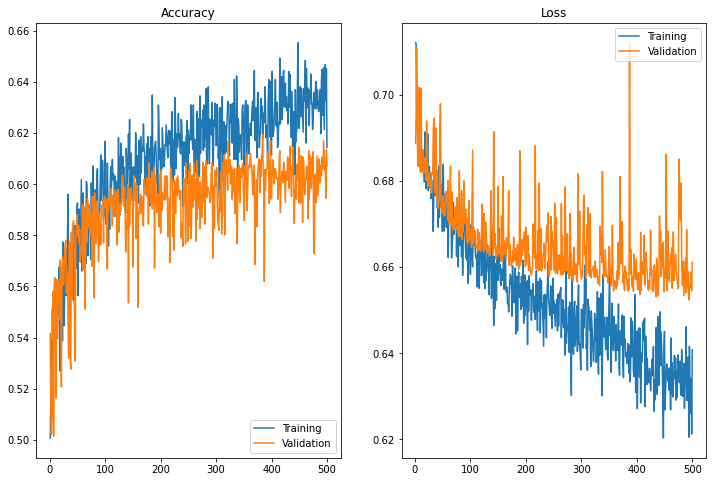

In [ ]:
# Evaluate the model
# Score
score = model.evaluate(test_features, test_labels, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

# Accuracy and Loss Transision
import matplotlib.pyplot as plt

epochs_range = range(1, len(history.history['acc'])+1)

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training')
plt.plot(epochs_range, history.history['val_acc'], label='Validation')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training')
plt.plot(epochs_range, history.history['val_loss'], label='Validation')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model(MODEL_DIR+'/'+MODEL_NAME+'.h5')

vTrue		Predicted


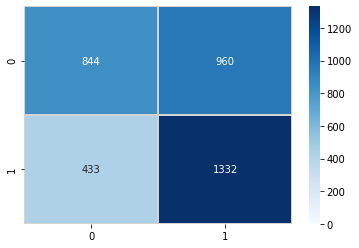

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calc confusion matrix
pred_labels = np.argmax(model.predict(test_features), axis=1)
ans_labels = np.argmax(test_labels, axis=1)
cm = confusion_matrix(ans_labels, pred_labels)

# Show
sns.heatmap(cm, vmin=0, cmap='Blues', annot=True, fmt='', linewidths=0.3, linecolor='lightgray')
print("vTrue\t\tPredicted")